In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as pltfrom 

from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop
from keras.utils import np_utils
import seaborn as sns 
sns.set_style('white')


Using TensorFlow backend.


In [2]:
# %load helpers.py
import numpy as np
import contextlib

def combine_histories(h1, h2):
    """
    Combine two history dicts -- appends the value lists to each other.

    Returns new dict.
    """
    d = {}
    for k in h1:
        d[k] = np.append(h1[k],h2[k])
    return d


# Some magic to make numpy arrays look prettier
@contextlib.contextmanager
def printoptions(*args, **kwargs):
    original = np.get_printoptions()
    np.set_printoptions(*args, **kwargs)
    yield 
    np.set_printoptions(**original)


In [3]:
# %load display.py
"""
Display utilities.
"""
# (Note: I ran
# pip install pydot==1.1.0
# and pip install graphviz
# and installed the graphviz OS X package with binary libraries
# to get this to work. May not actually need the pydot downgrade...)
from IPython.display import SVG

import keras
try:
    from keras.utils.vis_utils import model_to_dot
except ImportError:
    # 1.x had a different module name.
    from keras.utils.visualize_util import model_to_dot
    

import itertools as it
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.metrics import confusion_matrix


def visualize_keras_model(model):
    return SVG(model_to_dot(model).create(prog='dot', format='svg'))


def plot_training_curves(history):
    """
    Plot accuracy and loss curves for training and validation sets.

    Args:
        history: a Keras History.history dictionary

    Returns:
        mpl figure.
    """
    fig, (ax_acc, ax_loss) = plt.subplots(1, 2, figsize=(8,2))
    if 'acc' in history:
        ax_acc.plot(history['acc'], label='acc')
        if 'val_acc' in history:
            ax_acc.plot(history['val_acc'], label='Val acc')
        ax_acc.set_xlabel('epoch')
        ax_acc.set_ylabel('accuracy')
        ax_acc.legend(loc='upper left')
        ax_acc.set_title('Accuracy')

    ax_loss.plot(history['loss'], label='loss')
    if 'val_loss' in history:
        ax_loss.plot(history['val_loss'], label='Val loss')
    ax_loss.set_xlabel('epoch')
    ax_loss.set_ylabel('loss')
    ax_loss.legend(loc='upper right')
    ax_loss.set_title('Loss')

    sns.despine(fig)
    return fig


def plot_confusion_matrix(labels, predictions,
                          classes,
                          normalize=False,
                          title="Confusion matrix",
                          cmap=plt.cm.Blues):
    """
    Plot a confusion matrix for predictions vs labels.
    Both should be one-hot.

    Based on.
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    # convert from one-hot
    cat_labels = np.argmax(labels, axis=1)
    cat_predicts = np.argmax(predictions, axis=1)

    cm = confusion_matrix(cat_labels, cat_predicts)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)


    #print(cm)

    thresh = cm.max() / 2.
    for i, j in it.product(range(cm.shape[0]), range(cm.shape[1])):
        if 0 < cm[i,j] < 1:
            val = "{:.2f}".format(cm[i,j])
        else:
            val = cm[i,j]
        plt.text(j, i, val,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return cm


In [4]:
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

In [5]:
X_train=X_train.astype('float32')
X_test=X_test.astype('float32')
X_train=X_train/255.0
X_test=X_test/255.0

In [6]:
X_train=X_train.reshape(50000,3072)
X_test=X_test.reshape(10000,3072)

In [7]:
Y_train = np_utils.to_categorical(Y_train,10)
Y_test = np_utils.to_categorical(Y_test,10)


In [ ]:
epoch=100
numClasses=Y_test.shape[1]
batchSize=128

In [ ]:


model = Sequential()
model.add(Dense(1024, input_shape=(3072,), name="hidden"))
model.add(Activation('relu', name="ReLU"))
model.add(Dense(128, name="hidden1"))
model.add(Activation('softmax', name="ReLu"))
model.add(Dense(10, name="output"))
model.add(Activation('softmax', name="softmax"))

model.summary()


In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),              
              metrics=['accuracy'])

In [ ]:
history= model.fit(X_train,Y_train, epochs=10, batch_size=128, verbose=1);
plot_training_curves(history.history);


In [ ]:
score = model.evaluate(X_test,Y_test, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

In [ ]:
history1= model.fit(X_train,Y_train, epochs=50, batch_size=128, verbose=1);
#plot_training_curves((combine_histories(history.history, history1.history)));

In [ ]:
score = model.evaluate(X_test,Y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
history2= model.fit(X_train,Y_train, epochs=100, batch_size=128, verbose=1);
plot_training_curves(history2.history);


In [ ]:

score = model.evaluate(X_test,Y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
history3= model.fit(X_train,Y_train, epochs=75, batch_size=128, verbose=1);
plot_training_curves((combine_histories(history1.history,history3.history)));


In [ ]:
score = model.evaluate(X_test,Y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
history= model.fit(X_train,Y_train, epochs=100, batch_size=64, verbose=1);
plot_training_curves(history);

In [ ]:
score = model.evaluate(X_test,Y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
history= model.fit(X_train,Y_train, epochs=100, batch_size=256, verbose=1);
plot_training_curves(history.history);

In [ ]:
score = model.evaluate(X_test,Y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
model1 = Sequential()
model1.add(Dense(128,input_shape=(3072,), name="hidden1"))
model1.add(Activation('softmax', name="ReLu"))
model1.add(Dense(10, name="output"))
model1.add(Activation('softmax', name="softmax"))

model1.summary()


In [ ]:
model1.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),              
              metrics=['accuracy'])

In [ ]:
history= model1.fit(X_train,Y_train, epochs=100, batch_size=128, verbose=1);
plot_training_curves(history.history);

In [ ]:
score = model1.evaluate(X_test,Y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [8]:
model2 = Sequential()
model2.add(Dense(2048,input_shape=(3072,), name="hidden"))
model2.add(Activation('relu', name="Relu"))
model2.add(Dense(256, name="hidden1"))
model2.add(Activation('softmax', name="ReLu"))
model2.add(Dense(10, name="output"))
model2.add(Activation('softmax', name="softmax"))

model2.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 2048)              6293504   
_________________________________________________________________
Relu (Activation)            (None, 2048)              0         
_________________________________________________________________
hidden1 (Dense)              (None, 256)               524544    
_________________________________________________________________
ReLu (Activation)            (None, 256)               0         
_________________________________________________________________
output (Dense)               (None, 10)                2570      
_________________________________________________________________
softmax (Activation)         (None, 10)                0         
Total params: 6,820,618
Trainable params: 6,820,618
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model2.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),              
              metrics=['accuracy'])

Epoch 1/100
50000/50000 [==============================] - 22s - loss: 2.2966 - acc: 0.1178    
Epoch 2/100
50000/50000 [==============================] - 22s - loss: 2.2264 - acc: 0.1545    
Epoch 3/100
50000/50000 [==============================] - 22s - loss: 2.1719 - acc: 0.1632    
Epoch 4/100
50000/50000 [==============================] - 22s - loss: 2.1515 - acc: 0.1664    
Epoch 5/100
50000/50000 [==============================] - 22s - loss: 2.1510 - acc: 0.1669    
Epoch 6/100
50000/50000 [==============================] - 22s - loss: 2.1614 - acc: 0.1662    
Epoch 7/100
50000/50000 [==============================] - 22s - loss: 2.1303 - acc: 0.1741    
Epoch 8/100
50000/50000 [==============================] - 22s - loss: 2.1197 - acc: 0.1746    
Epoch 9/100
50000/50000 [==============================] - 23s - loss: 2.1209 - acc: 0.1739    
Epoch 10/100
50000/50000 [==============================] - 22s - loss: 2.1142 - acc: 0.1753    
Epoch 11/100
50000/50000 [=============

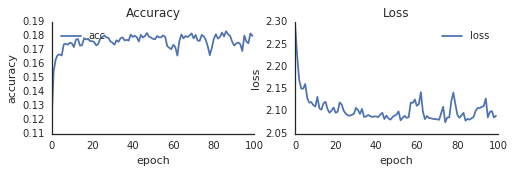

In [19]:
history= model2.fit(X_train,Y_train, epochs=100, batch_size=128, verbose=1);
plot_training_curves(history.history);

In [20]:
score = model2.evaluate(X_test,Y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

 9984/10000 [============================>.] - ETA: 0sTest loss: 2.07017459488
Test accuracy: 0.1812


In [18]:
model2.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),              
              metrics=['accuracy'])

In [17]:
model2 = Sequential()
model2.add(Dense(2048,input_shape=(3072,), name="hidden"))
model2.add(Activation('relu', name="Relu"))
model2.add(Dropout(0.25))
model2.add(Dense(256, name="hidden1"))
model2.add(Activation('softmax', name="ReLu"))
model2.add(Dense(10, name="output"))
model2.add(Activation('softmax', name="softmax"))

model2.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 2048)              6293504   
_________________________________________________________________
Relu (Activation)            (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
hidden1 (Dense)              (None, 256)               524544    
_________________________________________________________________
ReLu (Activation)            (None, 256)               0         
_________________________________________________________________
output (Dense)               (None, 10)                2570      
_________________________________________________________________
softmax (Activation)         (None, 10)                0         
Total para

In [ ]:
model2.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),              
              metrics=['accuracy'])

In [22]:
final_model = Sequential()
final_model.add(Dense(2048,input_shape=(3072,), name="hidden"))
final_model.add(Activation('relu', name="Relu"))
final_model.add(Dense(256, name="hidden1"))
final_model.add(Activation('softmax', name="ReLu"))
final_model.add(Dense(10, name="output"))
final_model.add(Activation('softmax', name="softmax"))

final_model.summary()
final_model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),              
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 2048)              6293504   
_________________________________________________________________
Relu (Activation)            (None, 2048)              0         
_________________________________________________________________
hidden1 (Dense)              (None, 256)               524544    
_________________________________________________________________
ReLu (Activation)            (None, 256)               0         
_________________________________________________________________
output (Dense)               (None, 10)                2570      
_________________________________________________________________
softmax (Activation)         (None, 10)                0         
Total params: 6,820,618
Trainable params: 6,820,618
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
50000/50000 [==============================] - 21s - loss: 2.3034 - acc: 0.0989    
Epoch 2/100
50000/50000 [==============================] - 21s - loss: 2.3028 - acc: 0.0997    
Epoch 3/100
50000/50000 [==============================] - 21s - loss: 2.3027 - acc: 0.0987    
Epoch 4/100
50000/50000 [==============================] - 20s - loss: 2.3028 - acc: 0.0987    
Epoch 5/100
50000/50000 [==============================] - 21s - loss: 2.3027 - acc: 0.0995    
Epoch 6/100
50000/50000 [==============================] - 21s - loss: 2.3027 - acc: 0.0999    
Epoch 7/100
50000/50000 [==============================] - 21s - loss: 2.3030 - acc: 0.0981    
Epoch 8/100
50000/50000 [==============================] - 21s - loss: 2.3032 - acc: 0.0980    
Epoch 9/100
50000/50000 [==============================] - 21s - loss: 2.3028 - acc: 0.0989    
Epoch 10/100
50000/50000 [==============================] - 20s - loss: 2.3028 - acc: 0.0971    
Epoch 11/100
50000/50000 [=============

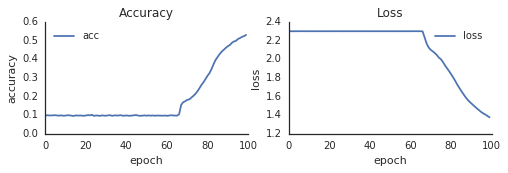

In [23]:
history= final_model.fit(X_train,Y_train, epochs=100, batch_size=128, verbose=1);
plot_training_curves(history.history);
score = final_model.evaluate(X_test,Y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])